# *Librerias y dependencias*:

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import logging
import os
import datetime
import json
import io
import pickle

# Graficos

import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score, accuracy_score

# For imbalaced data
from imblearn.over_sampling import SMOTE

# Utils funtions
from utils import get_features, predict_labels, generate_class_weights, get_label_class, display_side_by_side, normalizer

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, InputLayer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from keras import losses
from keras.optimizers import Adam

# Tensorflow
import tensorflow as tf

# Callbacks
from callbacks import PlotLearning
date = datetime.datetime.now().strftime("%d-%m-%Y,%H-%M-%S")

# *Configuraciones de la interfaz*:

In [2]:
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore') # Ignorar las advertencias
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Ignorar las advertencias

# __Limpieza de datos desde la tabla de excel:__

### Lectura del excel a un dataframe:

In [3]:
df_test = pd.read_excel('../datasets/Reporte Oficiales Remedy_ Lista de INC de usuarios Gestión de Operación de Cadenas - 2023.xlsx', header=3)
df_train = pd.read_excel('../datasets/Reporte Oficiales Remedy_ Lista de INC de usuarios Gestión de Operación de Cadenas -2022.xlsx', header=3)

### Variables de entorno:

In [4]:
COLUMNS = ["NOTAS", "RESUMEN", "PRIORIDAD"]
samples = 10000 # numero de muestras
maxlen = 200 # maxima longitud del vector
max_words = 5000 # maxima logitud de las notas
epochs = 25 # NUMERO DE ITERACIONES EN LA INTELIGENCIA ARTIFICIAL
batch_size = 256 # NUMERO DE LOTES POR ITERACION 
validation_split = 0.2 # CANTIDAD DE DATOS CON LOS CUALES SE VA A DIVIDIR EN ENTRENAMIENTO Y VALIDACION
num_classes = 4 # Numero de clases de la clasificacion
filename = f"logs-(precision)/log-{date}.csv" # Almacenamiento de indicadores
filepath_model = "machine_learning_file/ia_gestion_incidencias_prioridad.h5" # Archivo de la IA
filepath = "vectorizer-model" # Modelo de vectorizacion

# Reportes 2022-2023 

* archivo: __Excel Incidences (Reporte Oficiales Remedy_ Lista de INC de usuarios Gestión de Operación de Cadenas -2022)_
* archivo: __Excel Incidences (Reporte Oficiales Remedy_ Lista de INC de usuarios Gestión de Operación de Cadenas -2023)_

In [5]:
df_count_train = df_train[COLUMNS].groupby(by="PRIORIDAD", as_index=False).count()
df_count_test = df_test[COLUMNS].groupby(by="PRIORIDAD", as_index=False).count()

# Graficos de barras *Reporte-2022 vs Reporte-2023*

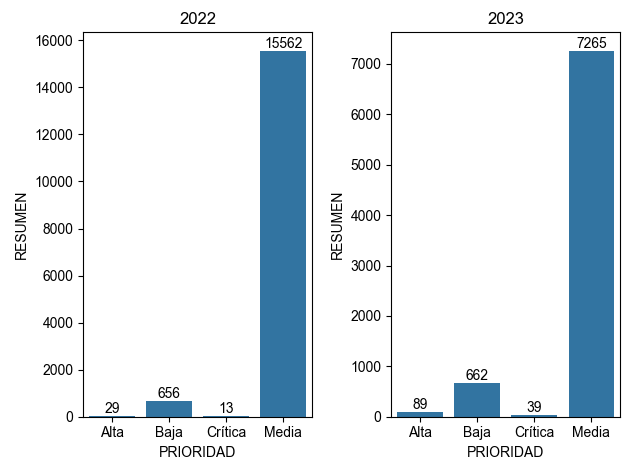

In [6]:
fig, axs = plt.subplots(ncols=2)
ax1 = sns.barplot(data=df_count_train, x="PRIORIDAD", y="RESUMEN", estimator="sum", ax=axs[0])
ax1.bar_label(ax1.containers[0], fontsize=10);
ax1.set_title("2022")
ax2 = sns.barplot(data=df_count_test, x="PRIORIDAD", y="RESUMEN", estimator="sum", ax=axs[1])
ax2.bar_label(ax2.containers[0], fontsize=10);
ax2.set_title("2023")
fig.tight_layout()
sns.set(rc={'figure.figsize':(20,15)})

# Limpiar y ajustar los datos para el entrenamiento:

> Eliminando los caracteres especiales.

In [7]:
def datasets(df, n=None, columns=COLUMNS):
    if n:
        df = df[columns][len(df)-n:]
    else:
        df = df[columns]
    df["NOTAS"] = df["NOTAS"].apply(lambda x: x.lower().replace('\n', ' '))
    df["NOTAS"] = df["NOTAS"].apply(lambda x: re.sub("[a-z]*(?=\:.+).(?=\ .+$)","",x))
    df["NOTAS"] = df["NOTAS"].apply(lambda x: re.sub("[0-9].*","", x))
    df["NOTAS"] = df["NOTAS"].apply(lambda x: re.sub("(?=\+).*","", x))
    df["RESUMEN"] = df["RESUMEN"].apply(lambda x: re.sub("([\/].|[-].)", "",x))
    df["RESUMEN"] = df["RESUMEN"].apply(lambda x: re.sub("^([A-Z]|[\[|(]).*([]|)])","", x))
    df["RESUMEN"] = df["RESUMEN"].apply(lambda x: re.sub("[^a-zA-Z\ ]","", x))
    df["RESUMEN"] = df["RESUMEN"].apply(lambda x: x.replace("\t", "").replace("\n", "").lower())
    df["PRIORIDAD"] = df["PRIORIDAD"].apply(lambda x: [x])
    return df
dataset_train = datasets(df_train, n=samples)
dataset_predict = datasets(df_test)
dataset_predict = dataset_predict
dataset_train

,NOTAS,RESUMEN,PRIORIDAD
6260,"estimados pasar las series a estado ""v"" (ticket, fecha de venta y precio) en siscad y pool de documentos pagados, figura mensaje de error al dar pago.",error al dar pago,[Media]
6261,"estimados pasar la serie a estado ""v"" (ticket, precio y fecha de venta) en siscad y pool de documentos pagados, figura mensaje de error al dar pago.",error al dar pago,[Media]
6262,"estimados apoyo en pasar la serie a estado ""v"" (ticket, fecha de venta y precio) en siscad y pool de documentos pagados, figura mensaje de error al dar pago.",error al dar pago,[Media]
6263,"estimados pasar la serie a estado ""v"" (ticket, precio y fecha de venta) en siscad y pool de documentos pagados, figura mensaje de error al dar pago.",error al dar pago,[Media]
6264,"estimados pasar la serie a estado ""v"" (ticket, precio y fecha de venta) en siscad y pool de documentos pagados, figura mensaje de error al dar pago.",error al dar pago,[Media]
...,...,...,...
16255,"estimados, por favor su apoyo para regularizar series que no puede ser vendida debido a que sistema me arroja mensaje de error(serie ya se encuentra vendida)solicito que se alinen series y se procedan vender en el sisact, series necesitan ser vendidas en el sisact ,serie se encuentra en estado (l)libre y en físico en el pdv adjunto evidencias.",equipo bloqueado,[Media]
16256,"estimados, venta se realizó de manera correcta en el pool de documentos pagados , su apoyo para que series pasen de estado (l)libre a estado (v) y en siscad todos los detalles (monto,fecha,ticket de venta) vendido con ticket",venta no descargada,[Media]
16257,"estimados, venta se realizó de manera correcta en el pool de documentos pagados , su apoyo para que series pasen de estado (l)libre a estado (v) y en siscad todos los detalles (monto,fecha,ticket de venta) vendido con ticket",venta no descargada,[Media]
16258,"estimados favor su apoyo para retirar del sigex-nuev loteo y de todas las bases del sigex , expediente cuya venta no fue concretada adjunto datos:vanessa andreina rodriguez castillo sec:",retirar expediente,[Media]


# Tokenizar y vectorizar a un sistema binario:

> Al dividir el texto en tokens, se facilita que los algoritmos de aprendizaje automático entiendan el significado del texto y, por lo tanto, se obtengan mejores resultados.

### Ejemplo:

* Clases que seria f(x) que obtenemos son las siguientes, en texto no podemos trabajar, las categorizamos en vectores y obtenemos: *[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]*
* Para x binarizamos el texto

In [8]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
import tensorflow as tf
# Definir el documento
text = """Estimados, Su apoyo con la regularización en el sistema debido que al momento de digitar las series para ingresar la venta  en SISCAT salta error No se ha encontrado ningún dato ", cuando estado de series en SISCAD es L, su apoyo para liberar serie y se pueda generar la venta de la misma."""
# Estimar el tamaño del vocabulario
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None, standardize="lower_and_strip_punctuation", split="whitespace", output_mode="count")
text_series = dataset_train['NOTAS']
text_vectorizer.adapt(text_series, batch_size=batch_size)
text_vectorizer.save_assets(os.getcwd())

# Vectorizacion:

La vectorización de textos es el proceso de convertir un texto en una representación numérica

In [9]:
vocab = text_vectorizer.get_vocabulary()
print("Vocab : {}".format(vocab[:10]))
print("Vocab Size : {}".format(text_vectorizer.vocabulary_size()))
out = text_vectorizer(text[:5])
print("Output Shape : {}".format(out.shape))
out

Vocab : ['[UNK]', 'de', 'en', 'estado', 'se', 'venta', 'el', 'con', 'que', 'estimados']
Vocab Size : 5899
Output Shape : (5899,)


<tf.Tensor: shape=(5899,), dtype=float32, numpy=array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string, name='text'))
model.add(text_vectorizer)
model.save(filepath, save_format="tf")

In [11]:
text_series = dataset_train['NOTAS']
multi_labels = dataset_train['PRIORIDAD']

# Convierte las categorias en vectores
mlb = MultiLabelBinarizer() # Instancia
binarize = mlb.fit_transform(np.unique(multi_labels.values))
mlb.fit_transform(multi_labels.values) # Entrenamiento
pickle.dump(mlb, open(' MultiLabelBinarizer.pk', 'wb')) # Crea un archivo para luego utilizarlo en la parte del backend
print(f"Binarizacion : {binarize}")
print(f"Clases : {mlb.classes_}")

Binarizacion : [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Clases : ['Alta' 'Baja' 'Crítica' 'Media']


# Balance de datos:

* Se combinaron tecnicas de sobremuestreo e inframuestreo.
* El __sobremuestreo aleatorio (oversampling)__ consiste en duplicar aleatoriamente ejemplos de la clase minoritaria y añadirlos al conjunto de datos de entrenamiento.
* El __submuestreo aleatorio (undersampling)__ consiste en seleccionar al azar ejemplos de la clase mayoritaria para eliminarlos del conjunto de datos de entrenamiento.

<h1>Dataset</h1>
<img src="https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_combine_001.png" width="250px" height="500px">
<h1>Resample dataset (Se utilizo el metodo SMOTEENN)</h1>
<img src="https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_combine_002.png" width="500px" height="1000px">

In [12]:
# Balance de los pesos de las categorias
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(sampling_strategy='all', k_neighbors=1) # Instancia
smotenn = SMOTEENN(random_state=9000, smote=smote) # OverSampling and Resampling
x = text_vectorizer(text_series) # Vectorizacion de las notas
y = mlb.transform(multi_labels) # Transformacion binaria de las categorias
x_res, y_res = smotenn.fit_resample(x,y) # Entrenamiento para el oversampling
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=9000) # Division de datos

# Pesos de las clases:

> Los pesos o ponderaciones establecen las normas para la intensidad de la señal de la neurona. Este valor determinará la influencia que tienen los datos de entrada en el producto de salida. Los sesgos proporcionan características extra con un valor de 1 que la red neuronal no tenía previamente. La red neuronal necesita esa información extra para propagarse eficientemente hacia adelante.

In [26]:
class_weights = generate_class_weights(np.argmax(y_train, axis=1))
[f"{k} : {v}->{mlb.classes_[i]})" for i,(k,v) in enumerate(dict(class_weights).items())

SyntaxError: incomplete input (4251866462.py, line 2)

# Modelo de la IA

### Leyenda:

##### Binary_accuracy:
> La precisión binaria calcula el porcentaje de valores predichos (yPred) que coinciden con los valores reales (yTrue) para etiquetas binarias. Dado que la etiqueta es binaria, yPred consiste en el valor de probabilidad de que las predicciones sean iguales a 1.

##### Loss:
> Indica lo mala que fue la predicción del modelo en un solo ejemplo. Si la predicción del modelo es perfecta, la pérdida es cero; en caso contrario, la pérdida es mayor. El objetivo del entrenamiento de un modelo es encontrar un conjunto de pesos y sesgos que tengan una pérdida baja.

##### Epoch:
> Numero de iteraciones para el entrenamiento


### Curvas:

<span style="color:orange">*Esta curva corresponde a los valores de validación del dataset.*</span>
<br>
<span style="color:blue">*Esta curva corresponde a los valores de entrenamiento.*</span>


### Funcion error -> __Categorical Cross Entropy__:

> Es una función de optimización que se utiliza para entrenar un modelo de clasificación que clasifica los datos prediciendo la probabilidad de que pertenezcan a una u otra clase. Uno de los ejemplos en los que se utiliza la función de pérdida de entropía cruzada es la regresión logística.


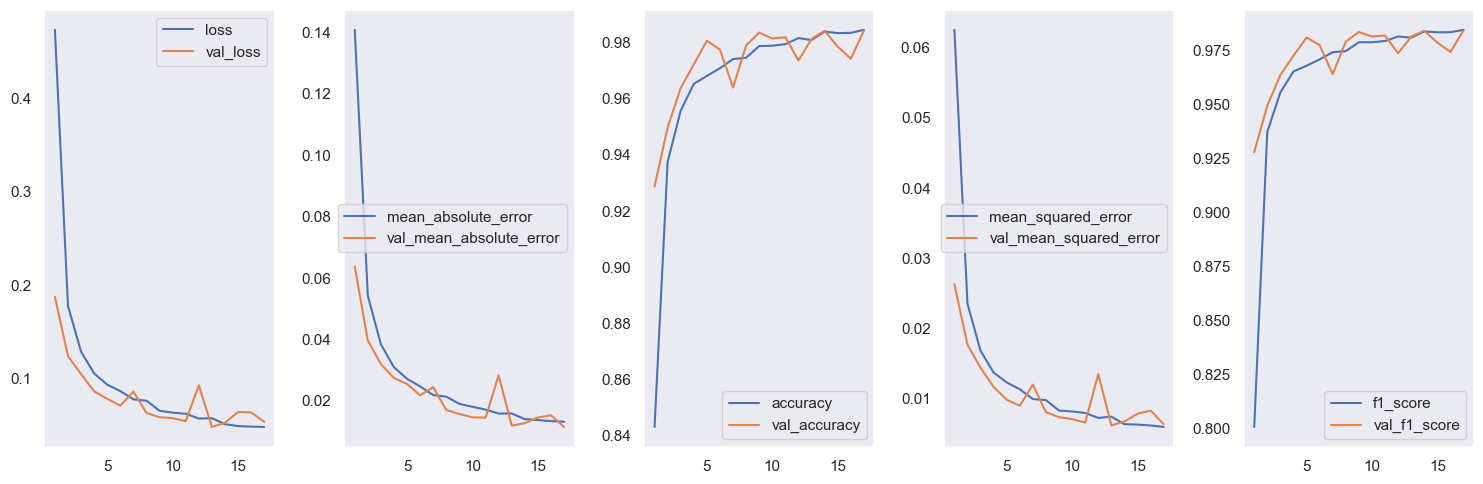

103/103 [==============================] - 5s 52ms/step - loss: 0.0484 - mean_absolute_error: 0.0132 - accuracy: 0.9846 - mean_squared_error: 0.0059 - f1_score: 0.9846 - val_loss: 0.0539 - val_mean_absolute_error: 0.0115 - val_accuracy: 0.9842 - val_mean_squared_error: 0.0064 - val_f1_score: 0.9843 - lr: 0.0010
(None, 5899)
(None, 5899)
(None, 128)
(None, 128)
(None, 64)
(None, 4)


In [14]:
import tensorflow_addons as tfa 

model = Sequential() # Agrupa secuencialmente una pila lineal de capas en un tf.keras.Model
model.add(Flatten()) # Aplana la entrada. No afecta al tamaño del lote.
model.add(Dropout(0.1)) # La capa Dropout establece aleatoriamente las unidades de entrada a 0 con una frecuencia de tasa en cada paso durante el tiempo de entrenamiento, lo que ayuda a prevenir el sobreajuste.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu')) # Dense implementa la operación: output = activation(dot(input, kernel) + bias) (la funcion activacion en la Relu)
model.add(Dense(mlb.classes_.shape[0], activation='softmax')) # Dense implementa la operación: output = activation(dot(input, kernel) + bias) (la funcion de activacion es la softmax)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["mean_absolute_error", "accuracy", "mean_squared_error", tfa.metrics.F1Score(num_classes=num_classes, average='micro', threshold=0.5)]) #  La entropía cruzada entre dos distribuciones de probabilidad mide el número medio de bits necesarios para identificar un evento de un conjunto de posibilidades

callbacks = [
    PlotLearning(),
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4,restore_best_weights=True), 
    ModelCheckpoint(filepath=filepath_model, save_best_only=True),
    CSVLogger(filename, separator=",", append=True),
    TensorBoard(update_freq=1, log_dir='logs',write_images=True),
]

history = model.fit(x_train, y_train,
                    class_weight=class_weights,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

for layer in model.layers:
    print(layer.output_shape) # Filas y columnas de la neurona

# *__Metricas o Indicadores__*

In [15]:
metrics = pd.DataFrame(data=history.history)[["mean_absolute_error", "accuracy", "mean_squared_error", "f1_score"]]
metrics = metrics.rename(columns={"loss": "Perdida", "mean_absolute_error": "Error absoluto medio", "accuracy": "Precision", "mean_squared_error": "Error cuadratico medio"})
metrics.describe(include='all')

,Error absoluto medio,Precision,Error cuadratico medio,f1_score
count,17.000000,17.000000,17.000000,17.000000
mean,0.029404,0.966172,0.013150,0.963691
std,0.030632,0.033966,0.013523,0.043705
min,0.013189,0.843052,0.005943,0.800803
25%,0.015864,0.968167,0.007232,0.968016
50%,0.018998,0.978803,0.008275,0.978886
75%,0.027169,0.981634,0.012290,0.981549
max,0.140811,0.984581,0.062553,0.984632


# Reporte de clasificacion:

> Un informe de clasificación se utiliza para medir la calidad de las predicciones de un algoritmo de clasificación. Cuántas predicciones son Verdaderas y cuántas son Falsas. Más específicamente, los Verdaderos Positivos, los Falsos Positivos, los Verdaderos Negativos y los Falsos Negativos se utilizan para predecir las métricas de un informe de clasificación como se muestra a continuación.

### Precisión: 
> Se define como la relación entre verdaderos positivos y la suma de verdaderos y falsos positivos..

### Puntuación F1
> La F1 es la media armónica ponderada de la precisión y la recuperación. Cuanto más se acerque el valor de la puntuación F1 a 1,0, mejor será el rendimiento esperado del modelo.

### Error absoluto medio:
> El error absoluto es la diferencia entre un valor medido y un valor real.

### Error cuadratico medio:
> Cuantifica la diferencia entre los valores predichos y los valores reales. Un valor de MSE más bajo indica un mejor rendimiento, ya que significa que las predicciones del modelo de IA están más cerca de los valores reales.

In [16]:
metrics.tail(10) # Ultimas 10 medidas

,Error absoluto medio,Precision,Error cuadratico medio,f1_score
7,0.021358,0.974633,0.009765,0.974790
8,0.018998,0.978803,0.008275,0.978890
9,0.018072,0.978918,0.008153,0.978886
10,0.017147,0.979492,0.007929,0.979481
11,0.015864,0.981634,0.007232,0.981549
12,0.015881,0.980946,0.007403,0.981037
13,0.014049,0.983968,0.006339,0.983886
14,0.013758,0.983433,0.006276,0.983504
15,0.013398,0.983509,0.006158,0.983544
16,0.013189,0.984581,0.005943,0.984632


# Carga del modelo al archivo

In [17]:
cnn_model = keras.models.load_model(filepath_model) # Cargamos el modelo generado
metrics = cnn_model.evaluate(x_test, y_test) # Se evalua con respecto al dataset de pruebas
print("Error: {}%".format(metrics[0])) #Error absoluto

205/205 [==============================] - 1s 3ms/step - loss: 0.0485 - mean_absolute_error: 0.0119 - accuracy: 0.9813 - mean_squared_error: 0.0062 - f1_score: 0.9815
Error: 0.04845701903104782%


In [18]:
labels = mlb.classes_
predict_x = cnn_model.predict(x_test) # Prediccion 
classes_x = np.argmax(predict_x,axis=1)
classes_pred = get_label_class(labels, classes_x)

205/205 [==============================] - 1s 2ms/step


# Predicción con respecto a la tabla de 2022

In [19]:
text_series = dataset_predict['NOTAS']
x_ = text_vectorizer(text_series)
indexs = list(dataset_predict.index.tolist())

In [20]:
y_pred = cnn_model.predict(x_)
y_pred = predict_labels(normalizer(y_pred), mlb, indexs)

252/252 [==============================] - 1s 3ms/step


In [21]:
data = {
    "PRIORIDAD": y_pred,
    "NOTAS": text_series
}
prediction = pd.DataFrame(data=data)
prediction["PRIORIDAD"] = prediction["PRIORIDAD"].apply(lambda x: x[0][0][0]) 
_predict_df = pd.concat([
    prediction.reset_index(drop=1).add_suffix('_prediccion'),
    dataset_predict.reset_index(drop=1).add_suffix('_real')
  ], axis=1).fillna('')
_predict_df.to_excel(f"ejemplo_predicciones/predicciones-{date}.xlsx")

# Metricas o Indicadores de la segunda prediccion, respecto a otro dataset de prueba

In [22]:
text_series = dataset_predict['NOTAS']
x = np.stack(text_vectorizer(text_series))
y = mlb.transform(dataset_predict['PRIORIDAD'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)
result = model.evaluate(test_dataset)
_metrics = dict(zip(model.metrics_names, result))
_metrics = pd.DataFrame(data=_metrics, index=[0])
_metrics = _metrics.rename(columns={"loss": "Perdida", "mean_absolute_error": "Error absoluto medio", "accuracy": "Precision", "mean_squared_error": "Error cuadratico medio"})
_metrics.T

51/51 [==============================] - 0s 6ms/step - loss: 0.8336 - mean_absolute_error: 0.1011 - accuracy: 0.8051 - mean_squared_error: 0.0760 - f1_score: 0.8053


,0
Perdida,0.833576
Error absoluto medio,0.101097
Precision,0.805090
Error cuadratico medio,0.075977
f1_score,0.805340


# Graficos de los datasets, Prediccion vs Datos

In [23]:
df_count_prediction = prediction.groupby(by="PRIORIDAD", as_index=False).count()
dataset_predict["PRIORIDAD"] = dataset_predict["PRIORIDAD"].apply(lambda x: x[0] if type(x) is list else x)
df_real_dataset_count = dataset_predict.groupby(by="PRIORIDAD", as_index=False).count()

# Graficos de barra

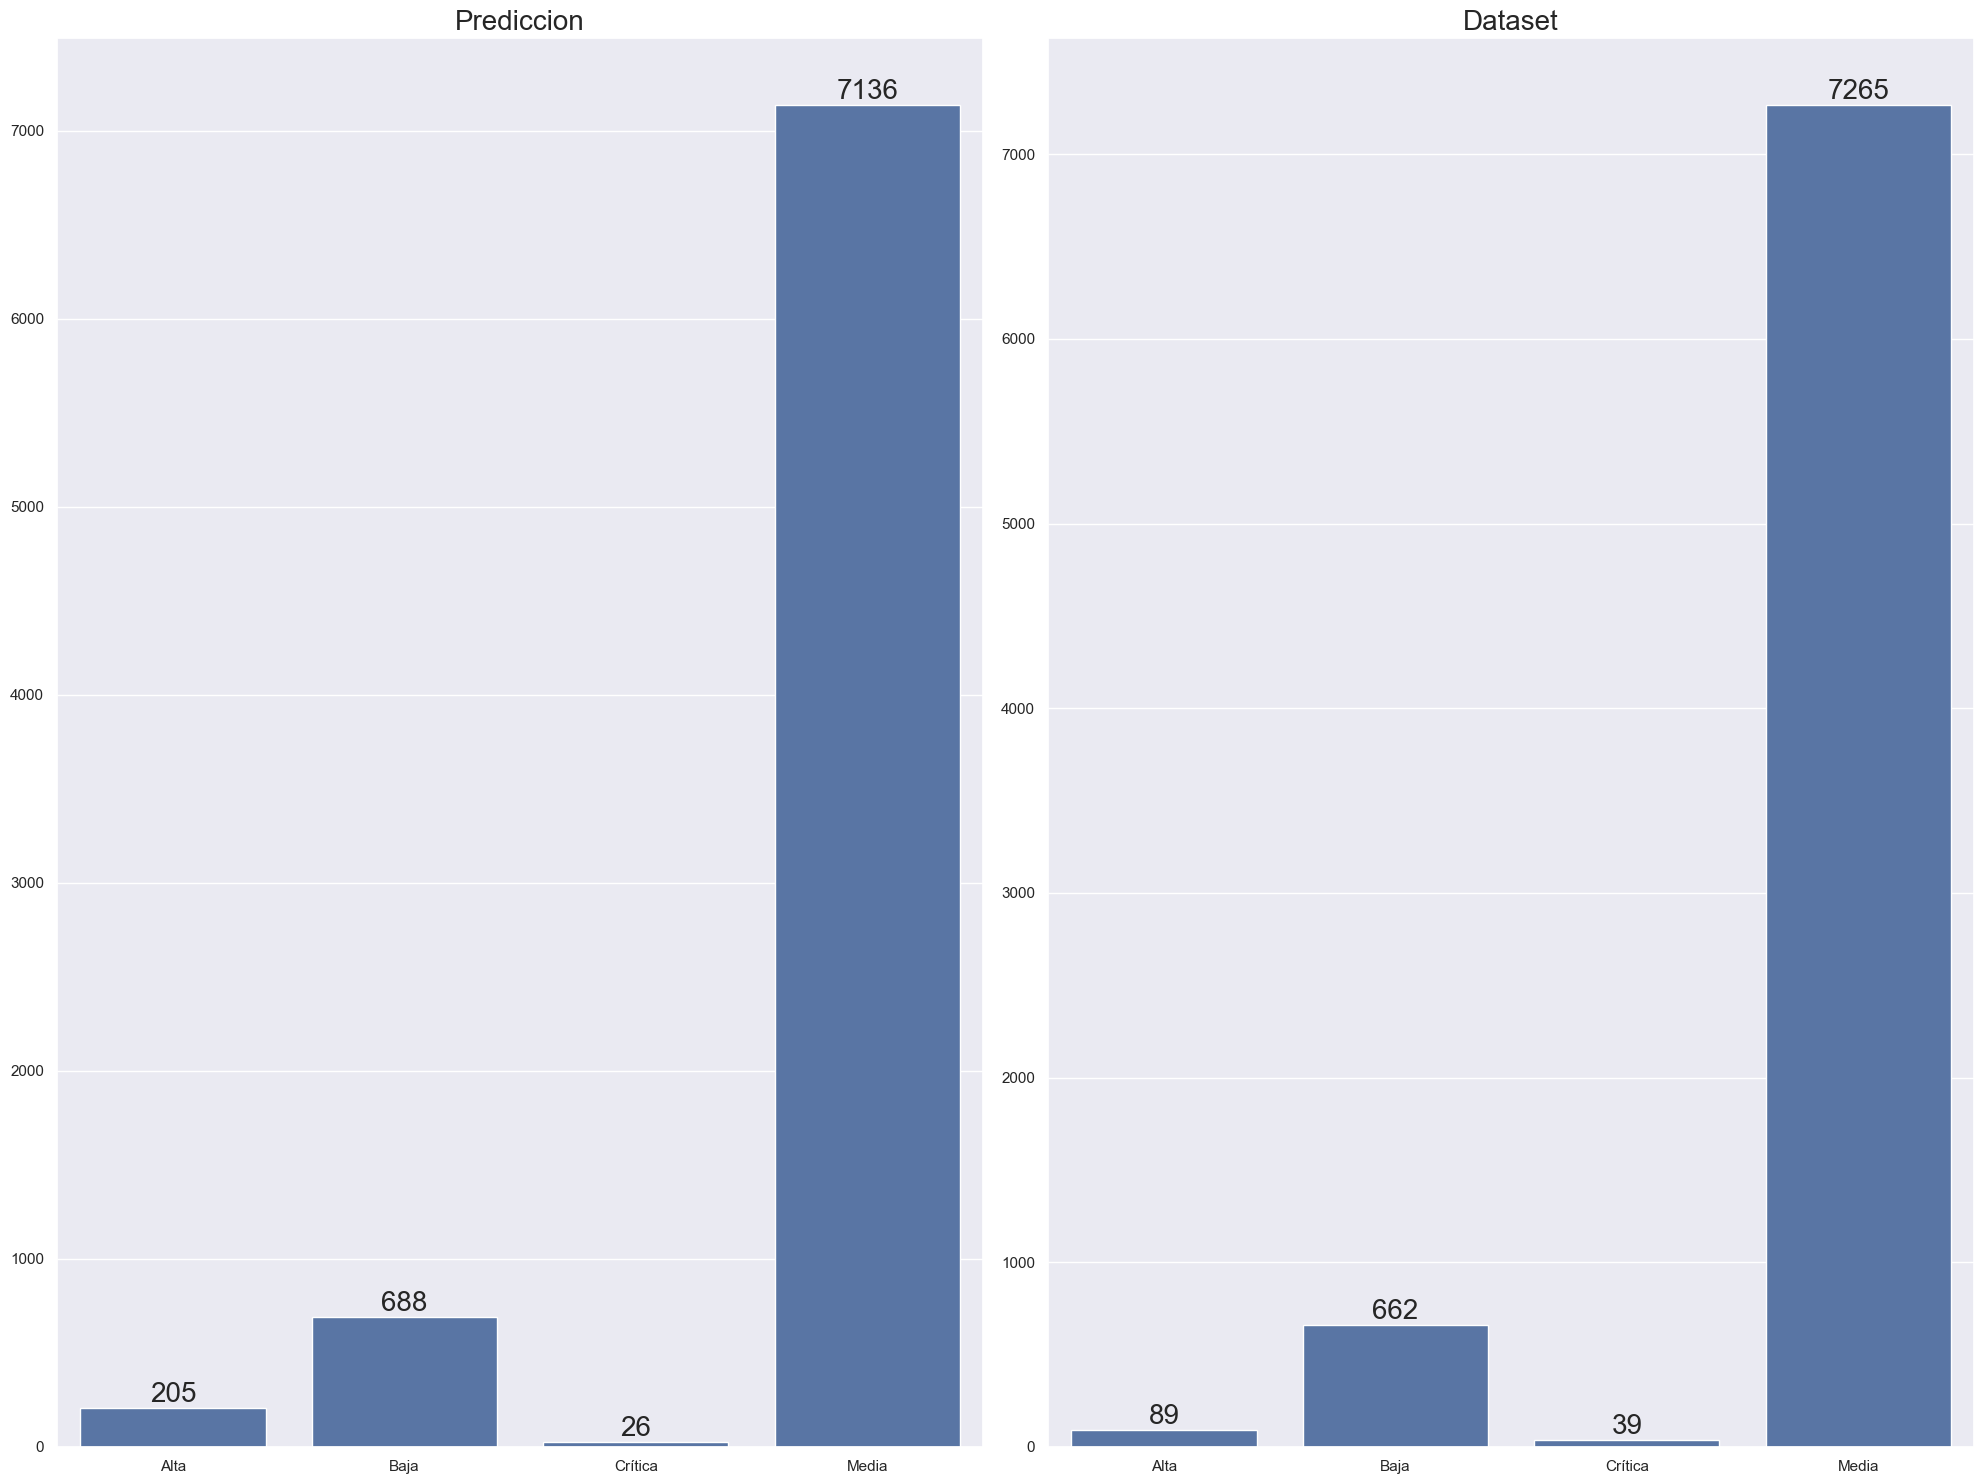

In [24]:
fig, axs = plt.subplots(ncols=2)
ax1 = sns.barplot(data=df_count_prediction , x="PRIORIDAD", y="NOTAS", ax=axs[0])
ax1.bar_label(axs[0].containers[0], fontsize=20)
ax1.set_title("Prediccion", fontsize=20)
ax1.set(xlabel="", ylabel="")
ax2 = sns.barplot(data=df_real_dataset_count, x="PRIORIDAD", y="NOTAS", ax=axs[1])
ax2.bar_label(axs[1].containers[0], fontsize=20)
ax2.set_title("Dataset", fontsize=20)
ax2.set(xlabel="", ylabel="")
sns.set(rc={'figure.figsize':(15,10)})
fig.tight_layout()